In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook as tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score
#from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

In [ ]:
import pickle
import random
import warnings
warnings.filterwarnings('ignore')

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/unbalaced_20_80_dataset.csv'
#data = pd.read_csv(filename, index_col=False)
data = pd.read_csv(filename, index_col=False,nrows=1616509)
print('Dataframe shape',data.shape)
data.tail(100)

Dataframe shape (1616509, 85)


,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1616409,6006856,172.31.64.114-23.15.8.121-52206-80-6,23.15.8.121,80,172.31.64.114,52206,6,20/02/2018 03:37:38,18,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1616410,6001987,172.31.0.2-172.31.64.114-53-59413-17,172.31.64.114,59413,172.31.0.2,53,17,20/02/2018 12:40:44,303,1,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1616411,7261946,172.31.64.57-5.188.136.46-3389-49210-6,5.188.136.46,49210,172.31.64.57,3389,6,20/02/2018 02:47:51,15050214,8,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1616412,3403362,172.31.0.2-172.31.66.109-53-62166-17,172.31.66.109,62166,172.31.0.2,53,17,20/02/2018 10:00:41,63764,2,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1616413,3683435,172.31.66.28-224.0.0.252-58019-5355-17,172.31.66.28,58019,224.0.0.252,5355,17,20/02/2018 01:59:00,420331,2,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616504,7360935,172.31.64.98-117.240.199.221-445-27304-6,172.31.64.98,445,117.240.199.221,27304,6,20/02/2018 02:40:31,113,2,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1616505,3859660,172.31.66.51-173.194.206.156-56200-443-6,173.194.206.156,443,172.31.66.51,56200,6,20/02/2018 05:00:10,12,2,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1616506,4236203,172.31.0.2-172.31.66.80-53-49482-17,172.31.66.80,49482,172.31.0.2,53,17,20/02/2018 01:39:31,52775,2,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1616507,2280877,172.31.64.45-216.58.211.163-51448-443-6,216.58.211.163,443,172.31.64.45,51448,6,20/02/2018 11:32:10,1,2,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [ ]:
nan_col = data.columns[data.isna().any()].tolist()
print('Columns with null values:\n',nan_col,'\n')
infinity = [np.inf, -np.inf]
inf_columns = []
for col in tqdm(data.columns):
 if data[col].isin(infinity).any():inf_columns.append(col)
print('\n Columns with inf or -inf values:\n',inf_columns,'\n')


Columns with null values:
 ['Flow Byts/s'] 



  0%|          | 0/85 [00:00<?, ?it/s]


 Columns with inf or -inf values:
 ['Flow Byts/s', 'Flow Pkts/s'] 



In [ ]:
data.replace([np.inf, -np.inf], np.nan,inplace=True)
print('Filling \'Flow Pkts/s\' nan values with mean :',data['Flow Pkts/s'].mean())
print('Filling \'Flow Byts/s\' nan values with mean :',data['Flow Byts/s'].mean())
data['Flow Byts/s'].fillna(data['Flow Byts/s'].mean(),inplace=True)
data['Flow Pkts/s'].fillna(data['Flow Pkts/s'].mean(),inplace=True)


Filling 'Flow Pkts/s' nan values with mean : 18113.466644833363
Filling 'Flow Byts/s' nan values with mean : 136605.93941644864


In [ ]:
drop_lst = []
catfeat = []
for col in tqdm(data.columns):
 if len(data[col].unique())==1:
  drop_lst.append(col)
 elif len(data[col].unique())<=2:
  catfeat.append(col)
catfeat.append('y')
print('Columns with single value:\n',np.array(drop_lst),'\n')
print('Categorical columns:\n',np.array(catfeat),'\n')


  0%|          | 0/85 [00:00<?, ?it/s]

Columns with single value:
 ['Fwd URG Flags' 'Bwd URG Flags' 'Fwd Byts/b Avg' 'Fwd Pkts/b Avg'
 'Fwd Blk Rate Avg' 'Bwd Byts/b Avg' 'Bwd Pkts/b Avg' 'Bwd Blk Rate Avg'] 

Categorical columns:
 ['Fwd PSH Flags' 'Bwd PSH Flags' 'FIN Flag Cnt' 'SYN Flag Cnt'
 'RST Flag Cnt' 'PSH Flag Cnt' 'ACK Flag Cnt' 'URG Flag Cnt'
 'CWE Flag Count' 'ECE Flag Cnt' 'Label' 'y'] 



In [ ]:
print('Dataframe shape before trimming:',data.shape)
# final_data = data
drop_lst.extend(['Label','Flow ID','Timestamp','Unnamed: 0'])
print('\nDropping following columns:\n',np.array(drop_lst))
final_data = data.drop(drop_lst,axis=1)
print('\nDataframe shape after trimming:',final_data.shape)


Dataframe shape before trimming: (1616509, 85)

Dropping following columns:
 ['Fwd URG Flags' 'Bwd URG Flags' 'Fwd Byts/b Avg' 'Fwd Pkts/b Avg'
 'Fwd Blk Rate Avg' 'Bwd Byts/b Avg' 'Bwd Pkts/b Avg' 'Bwd Blk Rate Avg'
 'Label' 'Flow ID' 'Timestamp' 'Unnamed: 0']

Dataframe shape after trimming: (1616509, 73)


In [ ]:
tqdm().pandas()
Y = data['Label']
final_data['y'] = data['Label'].progress_apply(lambda x: 1 if x=='ddos' else 0)
# timestamp = final_data['Timestamp']
final_data['Src IP'] = data['Src IP'].progress_apply(lambda x: int(('').join(x.split('.'))))
final_data['Dst IP'] = data['Dst IP'].progress_apply(lambda x: int(('').join(x.split('.'))))

0it [00:00, ?it/s]

  0%|          | 0/1616509 [00:00<?, ?it/s]

  0%|          | 0/1616509 [00:00<?, ?it/s]

  0%|          | 0/1616509 [00:00<?, ?it/s]

In [ ]:
print('\nFinal data shape:', final_data.shape)
final_data.head()



Final data shape: (1616509, 74)


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,y
0,1821919320,37882,172316925,80,6,8660,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,172316928,80,1821991,63287,6,5829,4,3,935.0,298.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,5214136135,63095,172316928,80,6,3396,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,18216200189,52341,172316928,80,6,2390,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,172316928,80,1821855126,57459,6,17362,4,3,935.0,314.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
lst = [i for i in final_data.columns if i not in catfeat]
print(len(lst))
print(np.array(lst))

63
['Src IP' 'Src Port' 'Dst IP' 'Dst Port' 'Protocol' 'Flow Duration'
 'Tot Fwd Pkts' 'Tot Bwd Pkts' 'TotLen Fwd Pkts' 'TotLen Bwd Pkts'
 'Fwd Pkt Len Max' 'Fwd Pkt Len Min' 'Fwd Pkt Len Mean' 'Fwd Pkt Len Std'
 'Bwd Pkt Len Max' 'Bwd Pkt Len Min' 'Bwd Pkt Len Mean' 'Bwd Pkt Len Std'
 'Flow Byts/s' 'Flow Pkts/s' 'Flow IAT Mean' 'Flow IAT Std' 'Flow IAT Max'
 'Flow IAT Min' 'Fwd IAT Tot' 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max'
 'Fwd IAT Min' 'Bwd IAT Tot' 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max'
 'Bwd IAT Min' 'Fwd Header Len' 'Bwd Header Len' 'Fwd Pkts/s' 'Bwd Pkts/s'
 'Pkt Len Min' 'Pkt Len Max' 'Pkt Len Mean' 'Pkt Len Std' 'Pkt Len Var'
 'Down/Up Ratio' 'Pkt Size Avg' 'Fwd Seg Size Avg' 'Bwd Seg Size Avg'
 'Subflow Fwd Pkts' 'Subflow Fwd Byts' 'Subflow Bwd Pkts'
 'Subflow Bwd Byts' 'Init Fwd Win Byts' 'Init Bwd Win Byts'
 'Fwd Act Data Pkts' 'Fwd Seg Size Min' 'Active Mean' 'Active Std'
 'Active Max' 'Active Min' 'Idle Mean' 'Idle Std' 'Idle Max' 'Idle Min']


In [ ]:
label = final_data['y']
X_train, X_test, y_train, y_test = train_test_split(final_data.drop(['y'],axis=1),label,test_size=0.2,random_state=42,stratify=label)
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)
print('y_train shape:',y_train.shape)
print('y_test shape:',y_test.shape)
print(y_train)

X_train shape: (1293207, 73)
X_test shape: (323302, 73)
y_train shape: (1293207,)
y_test shape: (323302,)
519413     1
748173     1
1230932    1
236512     1
1475000    0
          ..
419894     1
515201     1
1539593    0
138305     1
142483     1
Name: y, Length: 1293207, dtype: int64


In [ ]:
for i in tqdm(lst):
 minimum = X_train[i].min()
 maximum = X_train[i].max()
 X_train[i] = (X_train[i] - minimum)/(maximum - minimum)
 X_test[i] = (X_test[i] - minimum)/(maximum - minimum)


  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
X_train.head()


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
519413,0.000772,0.001221,0.000007,0.913068,0.352941,9.541667e-06,0.000015,0.000104,0.000113,0.000007,...,0.000004,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.00000
748173,0.008161,0.878096,0.000675,0.001221,0.352941,7.810250e-04,0.000008,0.000035,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.00000
1230932,0.000609,0.885725,0.000675,0.000320,0.352941,3.333333e-08,0.000000,0.000070,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.00000
236512,0.008161,0.629465,0.000675,0.001221,0.352941,3.150000e-06,0.000004,0.000035,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.00000
1475000,0.000772,0.791882,0.134023,0.006760,0.352941,5.147317e-01,0.000046,0.000383,0.000123,0.000116,...,0.000019,0.454545,0.044721,0.0,0.044721,0.044721,0.47352,0.0,0.47352,0.47352


In [ ]:
del final_data


In [ ]:
def cross_validation(mod):
 print('calling cross_val_score with cv=5 for test data:')
 scoring = ['f1', 'f1_macro']
 scores = cross_validate(mod, X_test, y_test, cv=5, scoring=scoring)
 return scores


In [ ]:
params = {'C': [ 0.01, 0.1, 10, 100] }
x_clf_1 = LogisticRegression(n_jobs=-1)
random_clf_1 = RandomizedSearchCV(x_clf_1, param_distributions=params, scoring='f1', verbose=10, cv=2)
random_clf_1.fit(X_train,y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START C=0.01......................................................
[CV 1/2; 1/4] END .......................C=0.01;, score=0.805 total time=  23.4s
[CV 2/2; 1/4] START C=0.01......................................................
[CV 2/2; 1/4] END .......................C=0.01;, score=0.756 total time=  22.9s
[CV 1/2; 2/4] START C=0.1.......................................................
[CV 1/2; 2/4] END ........................C=0.1;, score=0.805 total time=  20.6s
[CV 2/2; 2/4] START C=0.1.......................................................
[CV 2/2; 2/4] END ........................C=0.1;, score=0.756 total time=  20.1s
[CV 1/2; 3/4] START C=10........................................................
[CV 1/2; 3/4] END .........................C=10;, score=0.805 total time=  22.7s
[CV 2/2; 3/4] START C=10........................................................
[CV 2/2; 3/4] END .........................C=10;, 

RandomizedSearchCV(cv=2, estimator=LogisticRegression(n_jobs=-1),
                   param_distributions={'C': [0.01, 0.1, 10, 100]},
                   scoring='f1', verbose=10)

In [ ]:
print(random_clf_1.best_params_)
print(random_clf_1.best_score_)


{'C': 10}
0.7803441749277116


In [ ]:
model1 = LogisticRegression(C=random_clf_1.best_params_['C'], penalty='l2', random_state=42, n_jobs=-1, verbose=1)
model1.fit(X_train,y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LogisticRegression(C=10, n_jobs=-1, random_state=42, verbose=1)

In [ ]:
ypred = model1.predict(X_train)
# print(ypred)
f1score = f1_score(y_train, np.round(ypred))
print('f1_score for train:',f1score)
ypred = model1.predict(X_test)
f1score = f1_score(y_test, np.round(ypred))
print('f1_score for test:',f1score)
# Dumping model in pickle file
with open('LR.pkl', 'wb') as fp:
 pickle.dump(model1, fp, protocol=pickle.HIGHEST_PROTOCOL)


f1_score for train: 0.6704003522598011
f1_score for test: 0.6701526788061355


In [ ]:
infile = open('LR.pkl','rb')
model = pickle.load(infile)
infile.close()
scores = cross_validation(model)
print(scores)


calling cross_val_score with cv=5 for test data:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


{'fit_time': array([9.96051121, 7.76739764, 8.58825827, 7.47592616, 9.67270637]), 'score_time': array([0.11232567, 0.13193226, 0.1051414 , 0.11096525, 0.12540293]), 'test_f1': array([0.67456249, 0.84700007, 0.78643104, 0.69102937, 0.8462157 ]), 'test_f1_macro': array([0.54657255, 0.64159227, 0.60596448, 0.52027756, 0.66665462])}


In [ ]:
print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())


mean test f1_score:  0.769047734673472
mean test macro_f1:  0.5962122949000502


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


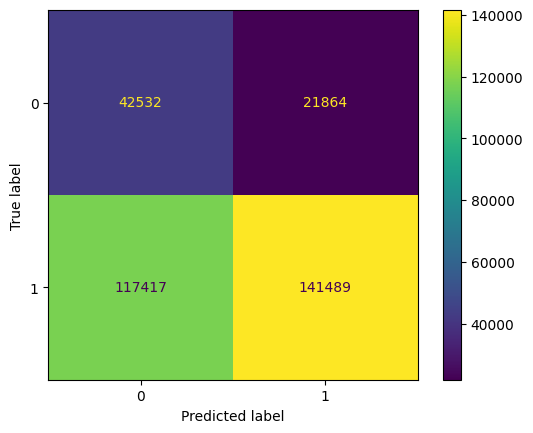

In [ ]:
cm = confusion_matrix(y_test, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp.plot(values_format='')  # Remove values from matrix cells
plt.show()


In [ ]:
var = np.logspace(0,-9, num=10)
print(var)
np.random.seed(999)
params = {'var_smoothing': var}
x_clf_2 = GaussianNB()
random_clf_2 = RandomizedSearchCV(x_clf_2, param_distributions=params, scoring='f1', verbose=10, cv=2)
random_clf_2.fit(X_train,y_train)

[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09]
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START var_smoothing=1.0..........................................
[CV 1/2; 1/10] END ...........var_smoothing=1.0;, score=0.902 total time=   6.4s
[CV 2/2; 1/10] START var_smoothing=1.0..........................................
[CV 2/2; 1/10] END ...........var_smoothing=1.0;, score=0.902 total time=   2.6s
[CV 1/2; 2/10] START var_smoothing=0.1..........................................
[CV 1/2; 2/10] END ...........var_smoothing=0.1;, score=0.903 total time=   2.6s
[CV 2/2; 2/10] START var_smoothing=0.1..........................................
[CV 2/2; 2/10] END ...........var_smoothing=0.1;, score=0.903 total time=   2.9s
[CV 1/2; 3/10] START var_smoothing=0.01.........................................
[CV 1/2; 3/10] END ..........var_smoothing=0.01;, score=0.896 total time=   3.2s
[CV 2/2; 3/10] START var_smoothing=0.01..................

RandomizedSearchCV(cv=2, estimator=GaussianNB(),
                   param_distributions={'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
                   scoring='f1', verbose=10)

In [ ]:
model2 = GaussianNB(var_smoothing=random_clf_2.best_params_['var_smoothing'])
model2.fit(X_train,y_train)


GaussianNB(var_smoothing=0.1)

In [ ]:
ypred = model2.predict(X_train)
f1score = f1_score(y_train, ypred)
print('f1_score for train:',f1score)
ypred = model2.predict(X_test)
f1score = f1_score(y_test, ypred)
print('f1_score for test:',f1score)
# Dumping model in pickle file
with open('NB.pkl', 'wb') as fp:
 pickle.dump(model2, fp, protocol=pickle.HIGHEST_PROTOCOL)


f1_score for train: 0.9032287328789228
f1_score for test: 0.9030868203099379


In [ ]:
infile = open('NB.pkl','rb')
model = pickle.load(infile)
infile.close()
scores = cross_validation(model)
print(scores)


calling cross_val_score with cv=5 for test data:
{'fit_time': array([0.64361668, 0.63227534, 0.61628795, 0.58158946, 1.071033  ]), 'score_time': array([0.14855599, 0.15404963, 0.14304304, 0.17589426, 0.14275217]), 'test_f1': array([0.9029895 , 0.90291355, 0.90362949, 0.9027331 , 0.90318472]), 'test_f1_macro': array([0.57193968, 0.57151684, 0.57699294, 0.56966966, 0.57353527])}


In [ ]:
print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())

mean test f1_score:  0.9030900736949183
mean test macro_f1:  0.5727308797265822


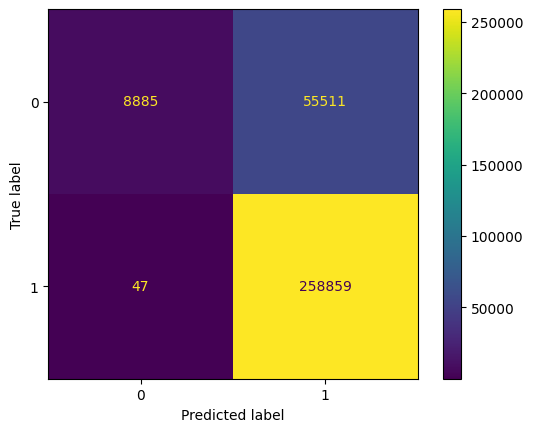

In [ ]:
cm = confusion_matrix(y_test, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp.plot(values_format='')  # Remove values from matrix cells
plt.show()


In [ ]:
from scipy.stats import randint
params = {'max_depth' : [3,5,8,None],
 'max_features': ['auto','log2',None],
 }
x_clf_5 = DecisionTreeClassifier()
random_clf_5 = RandomizedSearchCV(x_clf_5, param_distributions=params, scoring='f1', verbose=1, cv=2, n_jobs=3)
random_clf_5.fit(X_train,y_train)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=3,
                   param_distributions={'max_depth': [3, 5, 8, None],
                                        'max_features': ['auto', 'log2', None]},
                   scoring='f1', verbose=1)

In [ ]:
print(random_clf_5.best_params_)
print(random_clf_5.best_score_)


{'max_features': None, 'max_depth': None}
0.9999053716971934


In [ ]:
model5 = DecisionTreeClassifier(max_depth=None, max_features=None)
model5.fit(X_train,y_train)


DecisionTreeClassifier()

In [ ]:
ypred = model5.predict(X_train)
f1score = f1_score(y_train, np.round(ypred))
print('f1_score for train:',f1score)
ypred = model5.predict(X_test)
f1score = f1_score(y_test, np.round(ypred))
print('f1_score for test:',f1score)
# Dumping model in pickle file
with open('DT.pkl', 'wb') as fp:
 pickle.dump(model5, fp, protocol=pickle.HIGHEST_PROTOCOL)


f1_score for train: 1.0
f1_score for test: 0.999932408553601


In [ ]:
infile = open('DT.pkl','rb')
model = pickle.load(infile)
infile.close()
scores = cross_validation(model)
print(scores)

calling cross_val_score with cv=5 for test data:
{'fit_time': array([17.65949392, 18.36114883, 16.7863071 , 17.64941096, 17.76303768]), 'score_time': array([0.1360085 , 0.08404994, 0.08150649, 0.08525276, 0.13999915]), 'test_f1': array([0.9998262 , 0.99983586, 0.99984551, 0.99983585, 0.99971034]), 'test_f1_macro': array([0.99956364, 0.99958787, 0.99961212, 0.99958789, 0.99927265])}


In [ ]:
print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())

mean test f1_score:  0.9998107522440021
mean test macro_f1:  0.9995248346129328


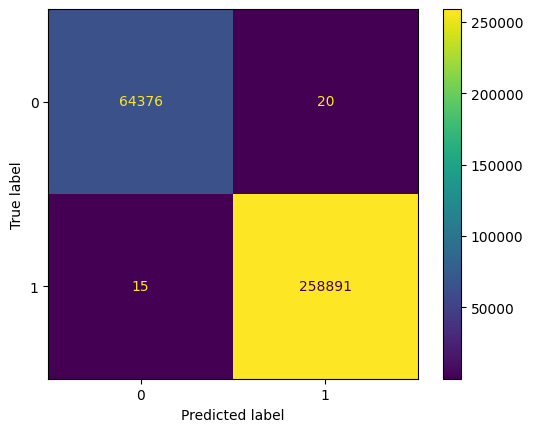

In [ ]:
cm = confusion_matrix(y_test, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp.plot(values_format='')  # Remove values from matrix cells
plt.show()
